In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [4]:
### Your code is here
# Создадим списки с именами категориальных и числовых колонок
categorical_columns = []
for i in range(len(df.dtypes)):
    if df.dtypes[i] == object:
        categorical_columns.append(df.columns[i])

num_columns = df.select_dtypes(exclude='object').columns

# Создадим список с самыми популярными значениями для каждой из категориальных фичей
most_popular_categorical = []
for i in categorical_columns:
    most_popular_categorical.append( df[f'{i}'].value_counts().index[0] )

# Заполним NaN-ы в категориальных колонках самым популярным значением
for i in range(len(categorical_columns)):
    df[f'{categorical_columns[i]}'] = df[f'{categorical_columns[i]}'].fillna(most_popular_categorical[i])
    
# Заполним NaN-ы в числовых колонках медианным значением
for i in num_columns:
    df[f'{i}'] = df[f'{i}'].fillna(df[f'{i}'].median())

In [5]:
# Смотрим, сколько уникальных значений в каждой из категориальных колонок
df[categorical_columns].nunique() 

Type_of_Cab                     5
Confidence_Life_Style_Index     3
Destination_Type               14
Gender                          2
dtype: int64

In [6]:
df = pd.concat((df, pd.get_dummies(df[categorical_columns], drop_first=True).astype(int)), axis=1).drop(categorical_columns, axis=1)

<Axes: >

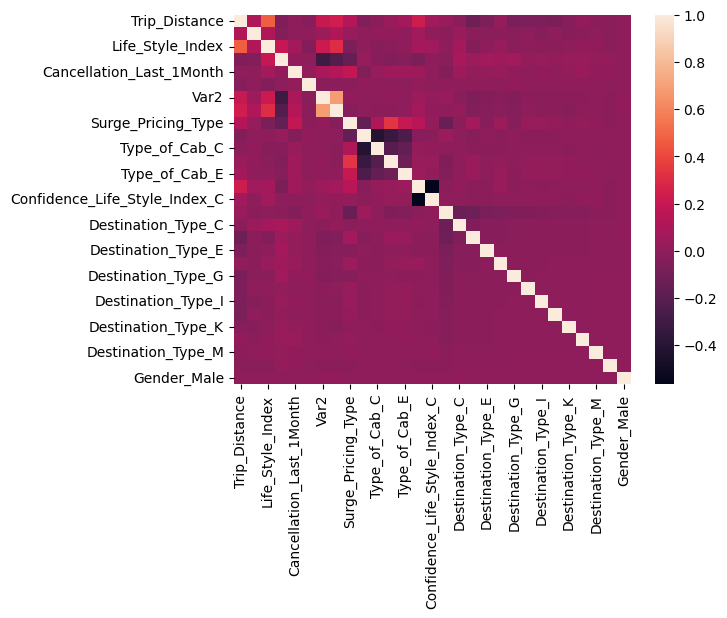

In [7]:
sns.heatmap(df.corr())

In [8]:
# Максимальное значение корреляции 
round(df.corr().replace(1, 0).max().max(), 3)

0.683

### Training

In [9]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('Surge_Pricing_Type', axis=1)
Y = df['Surge_Pricing_Type']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                   test_size=0.2,
                                                   shuffle=True,
                                                   random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [11]:
### Your code is here
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

pipe_lr = Pipeline(
    [('scaler', StandardScaler()),
    ('one_vs_all', OneVsRestClassifier(LogisticRegression()))])

pipe_lr.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [12]:
pd.DataFrame(classification_report(Y_test, pipe_lr.predict(X_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
1,0.722512,0.541884,0.619296,5372.000000
2,0.635589,0.834347,0.721530,11349.000000
3,0.740886,0.570849,0.644847,9612.000000
accuracy,0.678502,0.678502,0.678502,0.678502
macro avg,0.699662,0.649026,0.661891,26333.000000
weighted avg,0.691756,0.678502,0.672683,26333.000000


Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [13]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [14]:
### Your code is here
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipe_lr, param_grid)
clf.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_all',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_all__estimator__penalty': ['l1', 'l2',
                                                            'elasticnet']})

In [15]:
clf.best_params_

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}

In [16]:
pd.DataFrame(classification_report(Y_test, clf.predict(X_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
1,0.741727,0.534066,0.620996,5372.000000
2,0.634644,0.839369,0.722789,11349.000000
3,0.742321,0.575739,0.648503,9612.000000
accuracy,0.680857,0.680857,0.680857,0.680857
macro avg,0.706230,0.649724,0.664096,26333.000000
weighted avg,0.695793,0.680857,0.674907,26333.000000


Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

Text(0.5, 1.0, 'Calibration plots')

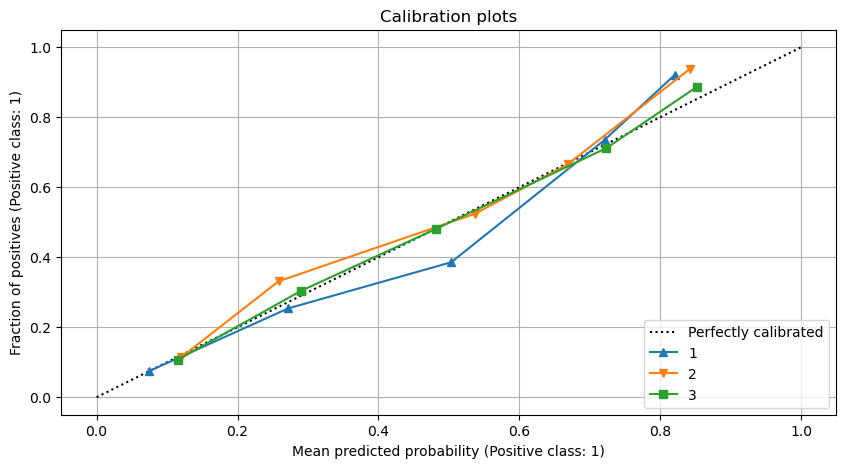

In [17]:
### Your code is here
from sklearn.calibration import CalibrationDisplay
### Отображение всех кривых на одном графике
fig, ax = plt.subplots(figsize=(10, 5))

names = ['1', '2', '3']
markers = ["^", "v", "s"]

for i in range(3):
    CalibrationDisplay.from_predictions(Y_test == i+1, pipe_lr.predict_proba(X_test)[:, i], ax=ax, name=names[i], marker=markers[i])

ax.grid()
ax.set_title("Calibration plots")

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [18]:
### Создание полиномиальных признаков
X_polinomial = X.copy()
### Your code is here
for col in num_columns.drop('Surge_Pricing_Type'):
    data_part = pd.concat([X[col]**(1+i) for i in range(4)], axis=1)
    data_part.columns = [col + f"_power_{i+1}" for i in range(4)]
    
    X_polinomial = X_polinomial.drop(col, axis=1)
    X_polinomial = pd.concat((X_polinomial, data_part), axis=1)
    
X_polinomial.shape

(131662, 52)

In [19]:
X_pol_train, X_pol_test, Y_train, Y_test  = train_test_split(X_polinomial, Y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [20]:
### Your code is here
pipe2 = Pipeline([('scaler', StandardScaler()), 
                  ('one_vs_all', OneVsRestClassifier(LogisticRegression(C=0.001, penalty='l2')))])

pipe2.fit(X_pol_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [21]:
pd.DataFrame(classification_report(Y_test, pipe2.predict(X_pol_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
1,0.748299,0.532390,0.622145,5372.000000
2,0.636023,0.836990,0.722797,11349.000000
3,0.740760,0.583854,0.653014,9612.000000
accuracy,0.682452,0.682452,0.682452,0.682452
macro avg,0.708361,0.651078,0.665985,26333.000000
weighted avg,0.697158,0.682452,0.676792,26333.000000


По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

Text(0.5, 1.0, 'Calibration plots')

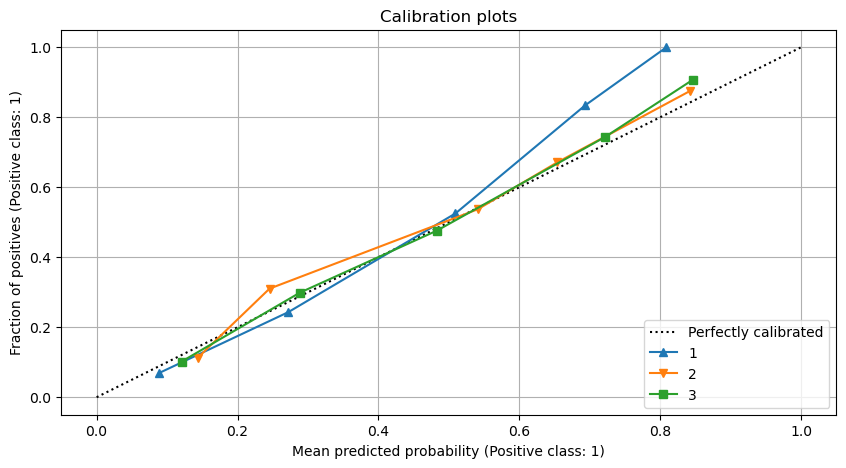

In [22]:
### Your code is here
### Отображение всех кривых на одном графике
### Отображение всех кривых на одном графике
fig, ax = plt.subplots(figsize=(10, 5))

names = ['1', '2', '3']
markers = ["^", "v", "s"]

for i in range(3):
    CalibrationDisplay.from_predictions(Y_test == i+1, pipe2.predict_proba(X_pol_test)[:, i], ax=ax, name=names[i], marker=markers[i])

ax.grid()
ax.set_title("Calibration plots")

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [23]:
X_train, X_test, y_train, y_test  = train_test_split(X, Y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [24]:
### Your code is here
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
pipe_ovo = Pipeline([('scaler', StandardScaler()), 
                     ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

pipe_ovo.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one', OneVsOneClassifier(estimator=SGDClassifier()))])

In [25]:
print(classification_report(y_test, pipe_ovo.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [26]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [27]:
### Your code is here
grid_ovo = GridSearchCV(pipe_ovo, param_grid)
grid_ovo.fit(X_train, y_train)

print(f"Best parameters: {grid_ovo.best_params_}")
pd.DataFrame(classification_report(y_test, grid_ovo.predict(X_test), digits=3, output_dict=True)).transpose()

Best parameters: {'one_vs_one__estimator__alpha': 0.1, 'one_vs_one__estimator__loss': 'hinge', 'one_vs_one__estimator__penalty': 'l2'}


,precision,recall,f1-score,support
1,0.756463,0.517498,0.614568,5372.000000
2,0.625086,0.876465,0.729734,11349.000000
3,0.761898,0.534644,0.628355,9612.000000
accuracy,0.678464,0.678464,0.678464,0.678464
macro avg,0.714482,0.642869,0.657552,26333.000000
weighted avg,0.701826,0.678464,0.669235,26333.000000
